### Imports

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from random import randrange
import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report

from utils.utility_functions import listdir_nohidden_sorted as lsdir
from vision.vision_utils.video_seq_generator import VideoSeqGenerator

### Paths

In [3]:
MED_FALL = "/home/jovyan/work/MED_Fall"
GROUND_TRUTH_PATH = f"{MED_FALL}/vision/vision_dataset/ground_truth_new"
FRAMES_PATH = f"{MED_FALL}/vision/vision_dataset/extracted_frames"

In [4]:
SEQ_LEN: int = 16
STRIDE: int = 8
BATCH_SIZE: int = 16
INPUT_SHAPE: tuple[int, int, int] = (112, 112, 3)

### Hyperparameters

### Utility Functions

In [5]:
def get_cam(name: str) -> int:
    """
    Extract cam number from each video frame name
    ------

    arguments:
        - name: string containing the frame name. Examle: 'Actor_1_bed_cam_1_0000'

    outputs:
        - cam_number: integer containg the cam number of the provided frame name.
                    Example: if name is 'Actor_1_bed_cam_1_0000', cam_number is: 1.
    """

    start = name.find("cam_")
    ind = start + 4
    cam_number = name[ind]
    return int(cam_number)


def show_frames_series(
    frames_series: np.array, title: str, figsize: tuple[int, int] = (20, 20), nrows=5
):
    """
    plot a series of SEQ_LEN frames with respective labels as titles.
    --------

    arguments:
        - frames_series: np.array containg SEQ_LEN images.
        - title: strcontainging the label of the series of frame. The label is calculated as the mode (most frequent label) of the single frames' labels.
        - fig_size: Optional. Tuple of two integers containing the figure dimensions for the plot. Default is (20, 20).

    """
    rows = nrows

    fig = plt.figure(figsize=figsize)
    for n, image in enumerate(frames_series):
        a = fig.add_subplot(rows, int(len(frames_series) / float(rows)), n + 1)

        plt.imshow(image)
        plt.axis("off")
    fig.suptitle(title)
    plt.show()

## Load Dataset

In [6]:
# Load all csv files (one per actor). Each file contains frames names and respective labels.
dfs = []
for file in lsdir(GROUND_TRUTH_PATH):
    df = pd.read_csv(file)
    dfs.append(df)
# concatenate all csv files in one pandas DF
dataset = pd.concat(dfs, ignore_index=True, axis=0)
dataset = dataset.iloc[:, 2:]
dataset

,micro_labels,macro_labels,ar_labels,frame_name
0,lie_still,lying_down,actor_repositioning,actor_1_bed_cam_1_0000
1,lie_still,lying_down,actor_repositioning,actor_1_bed_cam_1_0001
2,lie_still,lying_down,actor_repositioning,actor_1_bed_cam_1_0002
3,lie_still,lying_down,actor_repositioning,actor_1_bed_cam_1_0003
4,lie_still,lying_down,actor_repositioning,actor_1_bed_cam_1_0004
...,...,...,...,...
1182295,stand_up_from_floor,adl,actor_repositioning,actor_4_chair_full_ph_cam_7_4615
1182296,stand_up_from_floor,adl,actor_repositioning,actor_4_chair_full_ph_cam_7_4616
1182297,stand_up_from_floor,adl,actor_repositioning,actor_4_chair_full_ph_cam_7_4617
1182298,stand_up_from_floor,adl,actor_repositioning,actor_4_chair_full_ph_cam_7_4618


In [7]:
# Select only "on_air" frames (where actors are performing sequences)
dataset_onair = dataset.loc[dataset["ar_labels"] == "on_air"].copy()
dataset_onair

,micro_labels,macro_labels,ar_labels,frame_name
206,sit_up_from_lying,adl,on_air,actor_1_bed_cam_1_0206
207,sit_up_from_lying,adl,on_air,actor_1_bed_cam_1_0207
208,sit_up_from_lying,adl,on_air,actor_1_bed_cam_1_0208
209,sit_up_from_lying,adl,on_air,actor_1_bed_cam_1_0209
210,sit_up_from_lying,adl,on_air,actor_1_bed_cam_1_0210
...,...,...,...,...
1182213,crouched_still,falling,on_air,actor_4_chair_full_ph_cam_7_4533
1182214,crouched_still,falling,on_air,actor_4_chair_full_ph_cam_7_4534
1182215,crouched_still,falling,on_air,actor_4_chair_full_ph_cam_7_4535
1182216,crouched_still,falling,on_air,actor_4_chair_full_ph_cam_7_4536


In [8]:
# check on_air dataset samples per class
dataset_onair["macro_labels"].value_counts()

adl           269836
falling        88312
lying_down     27958
Name: macro_labels, dtype: int64

In [9]:
# instantiate and fit a OneHotEncoder for the macro classes (adl, fall, lie_down)
le = LabelBinarizer()
le.fit(dataset_onair["macro_labels"])
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
le_name_mapping

{'adl': array([1, 0, 0]),
 'falling': array([0, 1, 0]),
 'lying_down': array([0, 0, 1])}

## Use actor 3 as val set

In [10]:
actor_3 = dataset_onair.loc[dataset_onair["frame_name"].str.contains("actor_3")].copy()
actor_4 = dataset_onair.loc[dataset_onair["frame_name"].str.contains("actor_4")].copy()

actor_34 = pd.concat([actor_3, actor_4], axis=0)
actor_34

,micro_labels,macro_labels,ar_labels,frame_name
823349,sit_up_from_lying,adl,on_air,actor_3_bed_cam_1_0149
823350,sit_up_from_lying,adl,on_air,actor_3_bed_cam_1_0150
823351,sit_up_from_lying,adl,on_air,actor_3_bed_cam_1_0151
823352,sit_up_from_lying,adl,on_air,actor_3_bed_cam_1_0152
823353,sit_up_from_lying,adl,on_air,actor_3_bed_cam_1_0153
...,...,...,...,...
1182213,crouched_still,falling,on_air,actor_4_chair_full_ph_cam_7_4533
1182214,crouched_still,falling,on_air,actor_4_chair_full_ph_cam_7_4534
1182215,crouched_still,falling,on_air,actor_4_chair_full_ph_cam_7_4535
1182216,crouched_still,falling,on_air,actor_4_chair_full_ph_cam_7_4536


In [11]:
actor_12 = dataset_onair.drop(actor_34.index)
actor_12

,micro_labels,macro_labels,ar_labels,frame_name
206,sit_up_from_lying,adl,on_air,actor_1_bed_cam_1_0206
207,sit_up_from_lying,adl,on_air,actor_1_bed_cam_1_0207
208,sit_up_from_lying,adl,on_air,actor_1_bed_cam_1_0208
209,sit_up_from_lying,adl,on_air,actor_1_bed_cam_1_0209
210,sit_up_from_lying,adl,on_air,actor_1_bed_cam_1_0210
...,...,...,...,...
822862,fall_lateral,falling,on_air,actor_2_walk_stick_full_ph_cam_7_0982
822863,fall_lateral,falling,on_air,actor_2_walk_stick_full_ph_cam_7_0983
822864,fall_lateral,falling,on_air,actor_2_walk_stick_full_ph_cam_7_0984
822865,fall_lateral,falling,on_air,actor_2_walk_stick_full_ph_cam_7_0985


In [12]:
train_set = actor_12

In [13]:
train_set["macro_labels"].value_counts()

adl           182630
falling        60851
lying_down     23548
Name: macro_labels, dtype: int64

In [14]:
val_set = actor_3
val_set["macro_labels"].value_counts()

adl           61502
falling       14469
lying_down     3738
Name: macro_labels, dtype: int64

## Balance dataset

In [15]:
# dataset_balanced = dataset_onair.copy()  # make a copy of on_air dataset

counts = train_set["macro_labels"].value_counts()  # count samples per class
minority_class_samples = counts[-1]  # store minority class samples

# select adl samples
adl_samples = train_set.loc[dataset["macro_labels"] == "adl"]

# select fall samples
fall_samples = train_set.loc[dataset["macro_labels"] == "falling"]

## subsample

# count exceeding adl samples wrt minority_class_samples
adl_todrop_ind = len(adl_samples) - minority_class_samples
# count exceeding fall samples wrt minority_class_samples
fall_todrop_ind = len(fall_samples) - minority_class_samples

# select indices to drop from adl subset
adl_samples_to_drop = adl_samples.iloc[-adl_todrop_ind:]

# select indices to drop from fall subset
fall_samples_to_drop = fall_samples.iloc[-fall_todrop_ind:]

# actually drop exceeding adl samples
train_set.drop(adl_samples_to_drop.index, axis=0, inplace=True)

# actually drop exceeding fall samples
train_set.drop(fall_samples_to_drop.index, axis=0, inplace=True)

# count samples per class of the balanced dataset
train_set["macro_labels"].value_counts()

adl           23548
falling       23548
lying_down    23548
Name: macro_labels, dtype: int64

In [16]:
train_set.sort_index(inplace=True)

## Train test split

In [ ]:
# Take first 90% of the balanced dataset as train data and remaining 10% as val data.
# NB: no shuffling is applied as frames must be consecutive to later split them in time-series.
split_ratio = 0.9
split = int(len(dataset_balanced) * split_ratio)
train_set = dataset_balanced.iloc[:split, :].copy()
val_set = dataset_balanced.iloc[split:, :].copy()

minority_val_samples = val_set["macro_labels"].value_counts()[0]

# show samples per class in each set
print(train_set["macro_labels"].value_counts())
print(val_set["macro_labels"].value_counts())

In [ ]:
# show train set
train_set

In [ ]:
val_set_copy = pd.concat(
    [
        val_set,
        adl_samples_to_drop.iloc[0:minority_val_samples, :],
        fall_samples_to_drop.iloc[0:minority_val_samples, :],
    ],
    axis=0,
)
val_set_copy

In [ ]:
val_set_copy["macro_labels"].value_counts()

## Instantiate train and val generators
### VideoSeqGenerator works as follows:
- takes a dataframe containing the frame names and the corresponding labels as input
- splits the dataframe in time series of length SEQ_LEN
- for each series: 
    - loads a batch made of BATCH_SIZE * SEQ_LEN frames into a tensor called "X"
    - for each window (time-series) of the batch caluculates the mode of the frames, applies OneHotEncoding and stores the encoded windows' labels in a tensor called "y".
    - returns X,y. 
      X has shape (BATCH_SIZE, SEQ_LEN, IMAGE_SIZE), for example (32, 20, 224, 224, 3)
      y has shape (BATCH_SIZE, 3),  where 3 derives from the one hot encoding of the 3 classes (adl, fall, lie_down)

In [17]:
# instantiating train generator. For this test there will be only one generator which takes the whole dataset as input
train_gen = VideoSeqGenerator(
    frames_path=FRAMES_PATH,
    df=train_set,
    seq_len=SEQ_LEN,
    stride=STRIDE,
    batch_size=BATCH_SIZE,
    label_encoder=le,
    input_shape=INPUT_SHAPE,
)

(112, 112, 3)
<class 'tuple'>


In [18]:
val_gen = VideoSeqGenerator(
    frames_path=FRAMES_PATH,
    df=val_set,
    seq_len=SEQ_LEN,
    batch_size=BATCH_SIZE,
    stride=STRIDE,
    label_encoder=le,
    input_shape=INPUT_SHAPE,
)

(112, 112, 3)
<class 'tuple'>


In [29]:
train_gen.s_s[-1]

2192

In [30]:
len(val_gen.windows_labels)

311

In [31]:
pd.Series(val_gen.windows_labels).value_counts()

adl           222
falling        76
lying_down     13
dtype: int64

In [ ]:
len(train_gen.s_s)

In [19]:
train_gen.df["macro_labels"].value_counts()

adl           23548
falling       23548
lying_down    23548
Name: macro_labels, dtype: int64

In [32]:
print(len(train_gen.windows_labels))
pd.Series(train_gen.windows_labels).value_counts()

275


adl           200
falling        50
lying_down     25
dtype: int64

### Plot a frames series from first batch
    The first two images are black, in fact they are padding frames, because those two frames in the dataframe were part of another sequence. In other words, such frames had a different camera number with respect to the others.

batch_X.shape: (16, 16, 112, 112, 3) batch_y.shape: (16, 3)


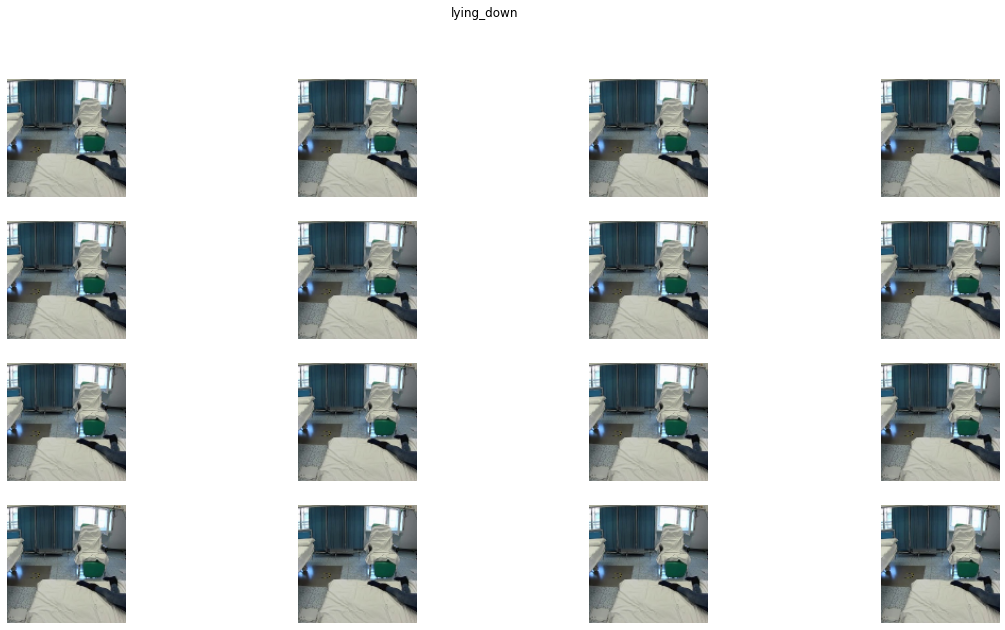

In [20]:
# get first batch from train generator

batch_number = randrange(0, 200)

batch_X, batch_y = train_gen.__getitem__(batch_number)
print("batch_X.shape:", batch_X.shape, "batch_y.shape:", batch_y.shape)

window_number = randrange(0, 15)

frames = batch_X[window_number]
title = np.expand_dims(batch_y[window_number], axis=0)
title = le.inverse_transform(title)[0]
title

show_frames_series(frames, title, figsize=(20, 10), nrows=4)

### Metrics

In [21]:
# we keep track of the recall (sensitivity, or number of correctly predicted true positive).
# This metric is especially important for the fall class, where we want to have maximum recall to be sure we don't miss any fall event.
metrics = [
    tf.keras.metrics.CategoricalAccuracy(),
    tf.keras.metrics.Recall(class_id=0, name="adl"),
    tf.keras.metrics.Recall(class_id=1, name="fall"),
    tf.keras.metrics.Recall(class_id=2, name="lying_down"),
]

2022-08-28 18:00:38.734491: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-28 18:00:39.173433: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19094 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:65:00.0, compute capability: 8.6


### Callbacks

In [22]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=f"{MED_FALL}/vision/models/3DCNN+ConvLSTM2D_balanced.h5"
)

callbacks = [model_checkpoint]

## Define 3D CNN Model
Architecture taken from:
Tran, D., Bourdev, L., Fergus, R., Torresani, L., & Paluri, M. (2015). Learning spatiotemporal features with 3d convolutional networks. In Proceedings of the IEEE international conference on computer vision (pp. 4489-4497).

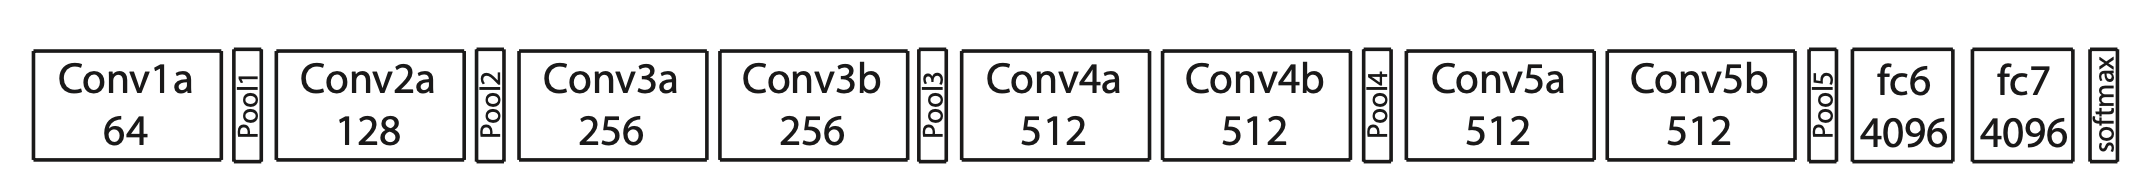

## Added ConvLSTM2D layers to the 3D CNN architecture

In [23]:
model = Sequential()
model.add(layers.Input(shape=(SEQ_LEN,) + INPUT_SHAPE))
model.add(layers.Rescaling(scale=1.0 / 255))
model.add(layers.Conv3D(64, (3, 3, 3), activation="relu", padding="same"))
model.add(layers.MaxPooling3D((1, 2, 2), strides=(1, 1, 1), padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))

model.add(layers.Conv3D(128, (3, 3, 3), activation="relu", padding="same"))
model.add(layers.MaxPooling3D((2, 2, 2), padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))

model.add(layers.Conv3D(256, (3, 3, 3), activation="relu", padding="same"))
model.add(layers.Conv3D(256, (2, 2, 2), activation="relu", padding="same"))
model.add(layers.MaxPooling3D((2, 2, 2), padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))

model.add(layers.Conv3D(512, (3, 3, 3), activation="relu", padding="same"))
model.add(layers.Conv3D(512, (2, 2, 2), activation="relu", padding="same"))
model.add(layers.MaxPooling3D((2, 2, 2), padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))

model.add(layers.Conv3D(512, (3, 3, 3), activation="relu", padding="same"))
model.add(layers.Conv3D(512, (2, 2, 2), activation="relu", padding="same"))
model.add(layers.MaxPooling3D((2, 2, 2), padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))

model.add(layers.ConvLSTM2D(256, (3, 3), return_sequences=True))
model.add(layers.BatchNormalization())

model.add(layers.Dropout(0.3))
model.add(layers.ConvLSTM2D(128, (3, 3)))
model.add(layers.BatchNormalization())

model.add(layers.Flatten())
model.add(layers.Dense(3, "softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 16, 112, 112, 3)   0         
_________________________________________________________________
conv3d (Conv3D)              (None, 16, 112, 112, 64)  5248      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 16, 112, 112, 64)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 112, 112, 64)  256       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 16, 112, 112, 128) 221312    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 8, 56, 56, 128)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 56, 56, 128)    5

### Compile Model

In [24]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=metrics)

### Fit Model

In [ ]:
history = model.fit(train_gen, validation_data=val_gen, epochs=50)

2022-08-28 18:01:03.995948: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-08-28 18:01:07.882974: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2022-08-28 18:01:16.037373: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


275/275 [==============================] - 257s 817ms/step - loss: 1.7043 - categorical_accuracy: 0.4539 - adl: 0.6071 - fall: 0.2922 - lying_down: 0.3395 - val_loss: 1.6459 - val_categorical_accuracy: 0.2522 - val_adl: 0.1684 - val_fall: 0.1558 - val_lying_down: 0.4915
Epoch 2/50
275/275 [==============================] - 225s 817ms/step - loss: 0.9969 - categorical_accuracy: 0.5702 - adl: 0.7152 - fall: 0.4087 - lying_down: 0.4415 - val_loss: 1.5080 - val_categorical_accuracy: 0.4369 - val_adl: 0.3605 - val_fall: 0.4030 - val_lying_down: 0.2222
Epoch 3/50
275/275 [==============================] - 224s 816ms/step - loss: 0.8675 - categorical_accuracy: 0.6175 - adl: 0.7879 - fall: 0.4026 - lying_down: 0.4990 - val_loss: 1.9502 - val_categorical_accuracy: 0.2721 - val_adl: 0.1766 - val_fall: 0.3983 - val_lying_down: 0.6282
Epoch 4/50
275/275 [==============================] - 225s 817ms/step - loss: 0.7482 - categorical_accuracy: 0.6614 - adl: 0.8253 - fall: 0.5027 - lying_down: 0.5133

In [26]:
model.save(f"{MED_FALL}/vision/models/3DCNN+ConvLSTM2D_balanced.h5")

In [ ]:
model = tf.keras.models.load_model(f"{MED_FALL}/vision/models/3DCNN+ConvLSTM2D.h5")

In [ ]:
model.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=callbacks)

In [ ]:
model = tf.keras.models.load_model(f"{MED_FALL}/vision/models/3DCNN+ConvLSTM2D.h5")

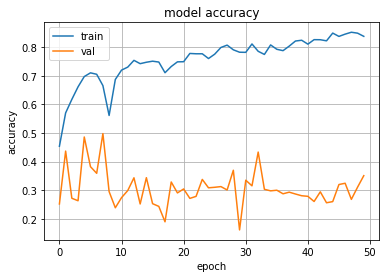

In [29]:
# plot the accuracies
plt.figure()
plt.plot(history.history["categorical_accuracy"])
plt.plot(history.history["val_categorical_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.grid()
plt.show()

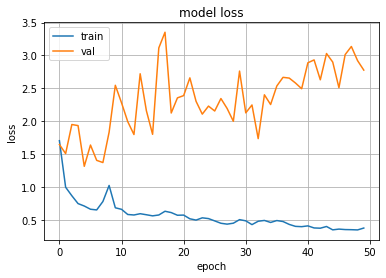

In [30]:
# plot the losses
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.grid()
plt.show()

In [ ]:
y_logits = model.predict(val_gen)
print(y_logits.shape)

In [ ]:
y_preds_encoded = []
for logit in y_logits:
    one_hot_labl = [0, 0, 0]
    argmax = np.argmax(logit, axis=0)
    one_hot_labl[argmax] = 1
    y_preds_encoded.append(one_hot_labl)

y_preds_encoded

In [ ]:
len(val_gen.windows_labels)

In [ ]:
y_true = val_gen.windows_labels[0:2448]
pd.Series(y_true).value_counts()

In [ ]:
y_true_encoded = le.transform(y_true)

In [ ]:
print(
    classification_report(
        y_true=y_true_encoded,
        y_pred=y_preds_encoded,
        target_names=["adl", "fall", "lie_down"],
    ),
)

In [ ]:
model.evaluate(train_gen)

In [ ]:
model.evaluate(val_gen)